# Portafolios de Inversión
## Proyecto Final

Presenta : 

- Juan Ramón López Rocha 

- José Armando Melchor Soto

- Paula Ines Pelayo Morales 
---



### Librerías 


In [611]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns


---

### Funciones

#### Función Analisis de Acciones 

In [587]:
def analizar_accion(ticker_f):
    accion = yf.Ticker(ticker_f)
    # Obtener datos
    info = accion.info
    current_price = info.get('regularMarketPrice', info.get('currentPrice', None))
    book_value_per_share = info.get('bookValue', None)
    trailing_eps = info.get('trailingEps', None)

    # Validar datos
    if None in (current_price, book_value_per_share, trailing_eps):
        return f"Error: No se pudo obtener alguno de los datos para {ticker_f}."

    # Cálculos
    price_to_book = current_price / book_value_per_share if book_value_per_share else None
    price_to_earnings = current_price / trailing_eps if trailing_eps else None

    # Evaluación P/B
    if price_to_book <= 1.2:
        evaluacion_pb = "P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett)."
    elif price_to_book <= 1.6:
        evaluacion_pb = "P/B entre 1.2–1.6: Valuación razonable (rango histórico)."
    else:
        evaluacion_pb = "P/B > 1.6: Posible sobrevaloración."

    # Evaluación P/E
    evaluacion_pe = f"P/E: {price_to_earnings:.2f}. Compara con el S&P 500 (~15–20) para contexto."

    # Resultados
    return (
        f"\nMétricas de {ticker_f}:\n"
        f"Precio Actual: ${current_price:.2f}\n"
        f"EPS (Trailing): ${trailing_eps:.2f}\n"
        f"Price-to-Book (P/B): {price_to_book:.2f}\n"
        f"Price-to-Earnings (P/E): {price_to_earnings:.2f}\n\n"
        f"Evaluación:\n{evaluacion_pb}\n{evaluacion_pe}"
    )


#### Clase Optimizar Pesos

In [588]:
class OptimizePortfolioWeights:

    def __init__(self, returns: pd.DataFrame, risk_free: float):

        self.rets = returns
        self.cov = returns.cov()
        self.rf = risk_free / 252
        self.n_stocks = len(returns.columns)
    
    # Min Variance
    def opt_min_var(self):
    

        var = lambda w: w.T @ self.cov @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 1)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=var, x0=w0, bounds=bounds, 
                        constraints={'fun': constraint, 'type': 'eq'}, 
                        tol=1e-16)

        return dict(zip(self.rets.columns, result.x)) 
    
    # Sharpe Ratio
    def opt_max_sharpe(self):
        rets = self.rets
        rend, cov, rf = self.rets.mean(), self.cov, self.rf

        sr = lambda w: -((np.dot(rend, w) - rf) / ((w.reshape(-1, 1).T @ cov @ w) ** 0.5))

        result = minimize(sr, np.ones(len(rets.T)), bounds=[(0, None)] * len(rets.T),
                          constraints={'fun': lambda w: sum(w) - 1, 'type': 'eq'},
                          tol=1e-16)

        return dict(zip(self.rets.columns, result.x)) 
    
    # Semivariance method
    def opt_min_semivar(self, rets_benchmark):
    
        rets, corr=self.rets.copy(), self.rets.corr()

        diffs=rets-rets_benchmark.values
        
        below_zero_target=diffs[diffs<0].fillna(0)
        target_downside=np.array(below_zero_target.std())

        target_semivariance=np.multiply(target_downside.reshape(len(target_downside), 1), target_downside) * corr
        
        semivar = lambda w: w.T @ target_semivariance @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 3)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=semivar, x0=w0, bounds=bounds, 
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return dict(zip(self.rets.columns, result.x)) 
    
    # Omega 
    def opt_max_omega(self, rets_benchmark):
    
        rets=self.rets.copy()

        diffs=rets-rets_benchmark.values
        
        below_zero_target=diffs[diffs<0].fillna(0)
        above_zero_target=diffs[diffs>0].fillna(0)

        target_downside=np.array(below_zero_target.std())
        target_upside=np.array(above_zero_target.std())
        o=target_upside/target_downside

        omega = lambda w: -sum(o * w)


        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 1)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=omega, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return dict(zip(self.rets.columns, result.x)) 


#### Clase Dynamic Backtesting

In [589]:
class dynamic_backtesting:
    
    # Definir las variables que necesitamos dentro de todas las funciones
    def __init__(self, prices, prices_benchmark, capital, rf, months):
        self.prices = prices
        self.prices_benchmark=prices_benchmark
        self.months = months
        self.capital = capital
        self.rf = rf
        
    # Clase para optimizar los pesos
    def optimize_weights(self, prices: pd.DataFrame, n_days: int, periods: int):
        
        temp_data = prices.iloc[int(n_days * periods):int(n_days * (periods + 1)), :]
        
        temp_bench = self.prices_benchmark.copy().iloc[int(n_days * periods):int(n_days * (periods + 1)), :]

        temp_rets = temp_data.pct_change(fill_method=None).dropna()
        rets_benchmark = temp_bench.pct_change(fill_method=None).dropna()

        
        optimizer = OptimizePortfolioWeights(returns=temp_rets, risk_free=self.rf)
        w_minvar=optimizer.opt_min_var()
        w_sharpe=optimizer.opt_max_sharpe()
        w_semivar=optimizer.opt_min_semivar(rets_benchmark)
        w_omega=optimizer.opt_max_omega(rets_benchmark)
        w_benchmark = 1

        return w_minvar, w_sharpe, w_semivar, w_omega, w_benchmark

    def simulation(self):
        
        n_days = round(len(self.prices) / round(len(self.prices) / 252 / (self.months / 12)), 0)
        
        capital = self.capital
             
        opt_data = self.prices.copy().iloc[:int(n_days), :]
        
        backtesting_data = self.prices.copy().iloc[int(n_days):, :]
        
        backtesting_rets = backtesting_data.pct_change(fill_method=None).dropna()
        backtesting_bench = self.prices_benchmark.copy().iloc[int(n_days):, :].pct_change(fill_method=None).dropna()

        
        day_counter, periods_counter = 0, 0 
        
        minvar, sharpe, semivar, omega , benchmark = [capital], [capital], [capital], [capital], [capital]
        
        w_minvar, w_sharpe, w_semivar, w_omega, w_benchmark  = self.optimize_weights(opt_data, n_days, 0)
        
        for day in range(len(backtesting_data) - 1):
            
            
            if day_counter < n_days:

                sharpe.append(sharpe[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_sharpe)))
                minvar.append(minvar[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_minvar)))
                semivar.append(semivar[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_semivar)))
                omega.append(omega[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_omega)))
                benchmark.append(benchmark[-1] * (1 + sum(backtesting_bench.iloc[day, :])))

            else:
                
                w_minvar, w_sharpe, w_semivar, w_omega = self.optimize_weights(backtesting_data, n_days, periods_counter)
                    
                sharpe.append(sharpe[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_sharpe)))
                minvar.append(minvar[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_minvar)))
                semivar.append(semivar[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_semivar)))
                omega.append(omega[-1] * (1 + sum(backtesting_rets.iloc[day, :] * w_omega)))
                benchmark.append(benchmark[-1] * (1 + sum(backtesting_bench.iloc[day, :])))
                
                periods_counter += 1
                day_counter = 0

            day_counter += 1
        
        df = pd.DataFrame()
        df['Date'] = backtesting_data.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Min Var'] = minvar
        df['Sharpe'] = sharpe
        df['Semivar'] = semivar
        df['Omega'] = omega
        df['Benchmark'] = benchmark
        df.set_index('Date', inplace=True)

        return df



#### Función Métricas de Desempeño

In [590]:
def metricas(history, rf):
    # Returns
    rets= history.pct_change().dropna()
    
    # Matriz de Cov
    cov_hist = rets.cov()

    # Dataframe
    metricas = pd.DataFrame(index=rets.columns)

    # Rendimiento 
    metricas['Rendimiento Promedio Anual'] = R_p = rets.mean()*252*100
    
    # Volatilidad 
    metricas['Volatilidad Anual'] = vol_anual = rets.std()*np.sqrt(252)*100
    
    # Ratio de Sharpe
    metricas['Ratio de Sharpe'] = (R_p - rf) / vol_anual

    # Downside Risk
    metricas['Downside Risk'] = downside = rets[rets < 0].fillna(0).std() * np.sqrt(252) * 100

    # Upside Risk
    metricas['Upside Risk'] = upside = rets[rets > 0].fillna(0).std() * np.sqrt(252) * 100

    # Omega
    metricas['Omega']=  upside / downside

    # Beta

    covs = cov_hist['Benchmark']
    varianza_market = covs['Benchmark']
    metricas['Beta'] = beta = covs / varianza_market

    # Alfa de Jensen

    R_m = rets['Benchmark'].mean() * 252 * 100
    metricas['Alpha']= R_p - (rf + beta * (R_m - rf))

    # Ratio de Treynor
    metricas['Ratio de Treynor'] = (R_p - rf) / beta

    # Ratio de Sortino
    metricas['Ratio de Sortino'] = (R_p - rf) / downside

    return metricas.T

---

### Obtención de Datos

In [591]:
tickers = yf.download(['BRK-B', 'AZO', 'META','NEM','ED','WMT'], start='2024-07-01', end='2025-07-01' ,progress=False)['Close']
benchmark = yf.download('^GSPC', start='2024-07-01', end='2025-07-01',progress=False)['Close']


In [592]:
ret = tickers.pct_change().dropna()
rets_benchmark = benchmark.pct_change().dropna()

In [593]:
corr = ret.corr()
corr

Ticker,AZO,BRK-B,ED,META,NEM,WMT
Ticker,,,,,,
AZO,1.000000,0.329155,0.329980,0.033521,0.167396,0.216213
BRK-B,0.329155,1.000000,0.307108,0.242895,0.193151,0.385952
ED,0.329980,0.307108,1.000000,-0.310581,0.171607,0.119700
META,0.033521,0.242895,-0.310581,1.000000,0.131950,0.415612
NEM,0.167396,0.193151,0.171607,0.131950,1.000000,0.266201
WMT,0.216213,0.385952,0.119700,0.415612,0.266201,1.000000


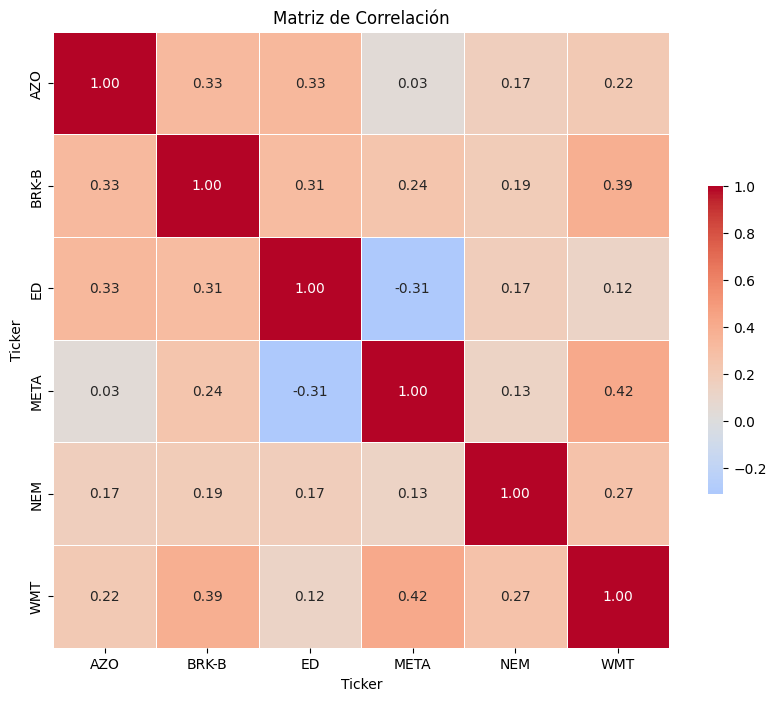

In [612]:
plt.figure(figsize=(10, 8))  # Tamaño del gráfico

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Matriz de Correlación')
plt.show()

In [594]:
tickers_valuation = ['AZO', 'META','NEM','ED','WMT']
def get_financials(ticker:str) -> pd.DataFrame:
    bs = yf.Ticker(ticker).balance_sheet.iloc[:, :-1]
    ist = yf.Ticker(ticker).income_stmt.iloc[:, :-1]
    cf = yf.Ticker(ticker).cash_flow.iloc[:, :-1]

    return bs, ist, cf

Múltiplos de AZO


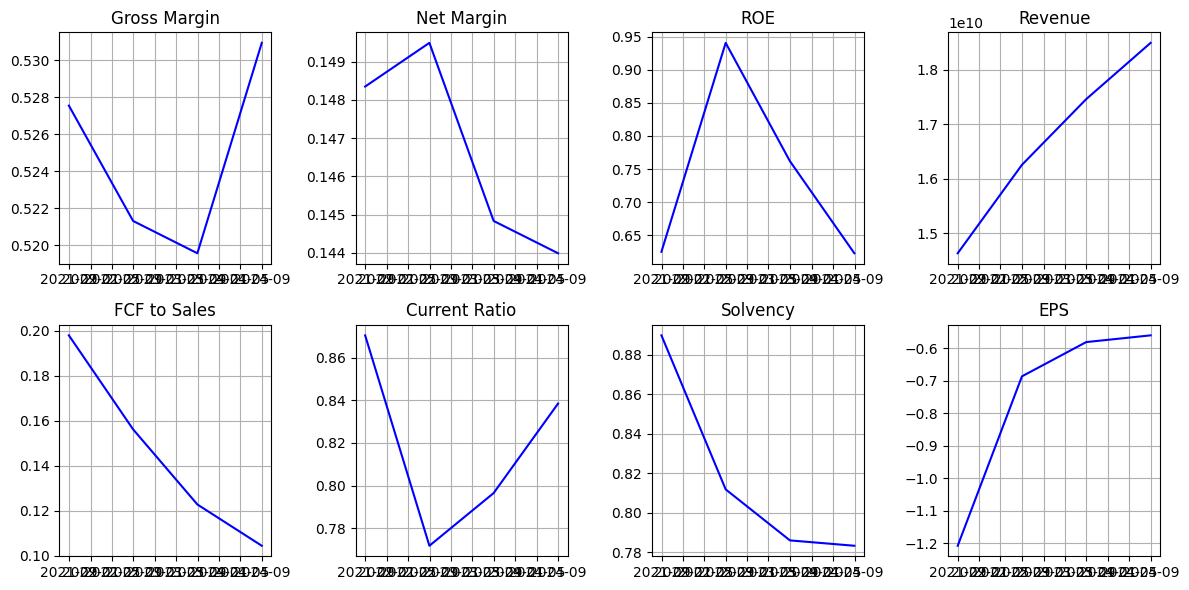

Múltiplos de META


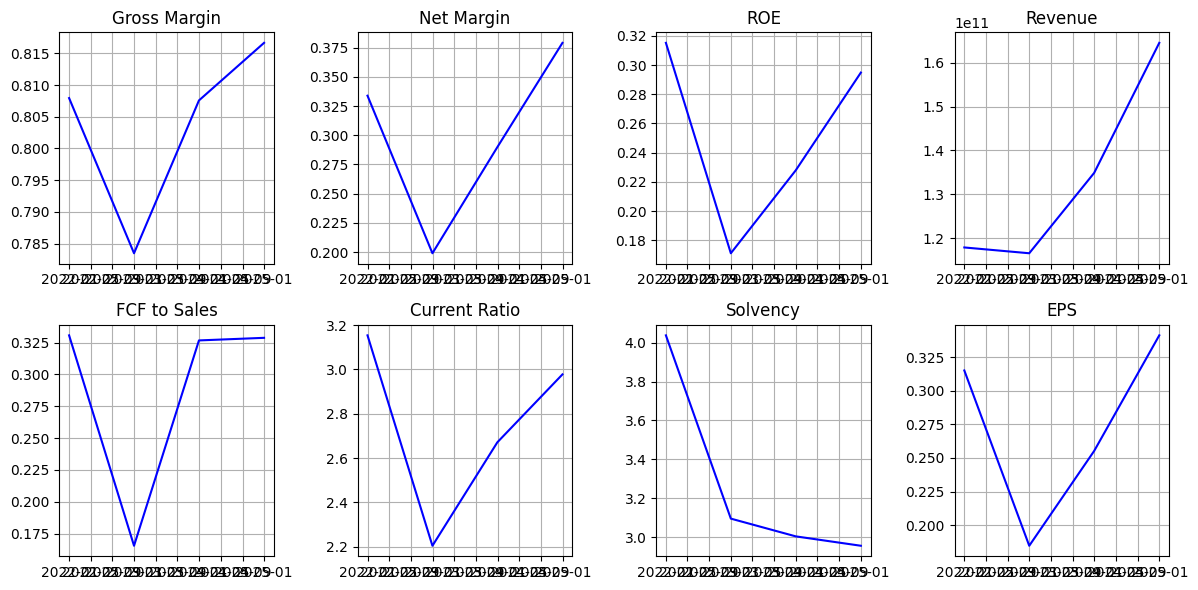

Múltiplos de NEM


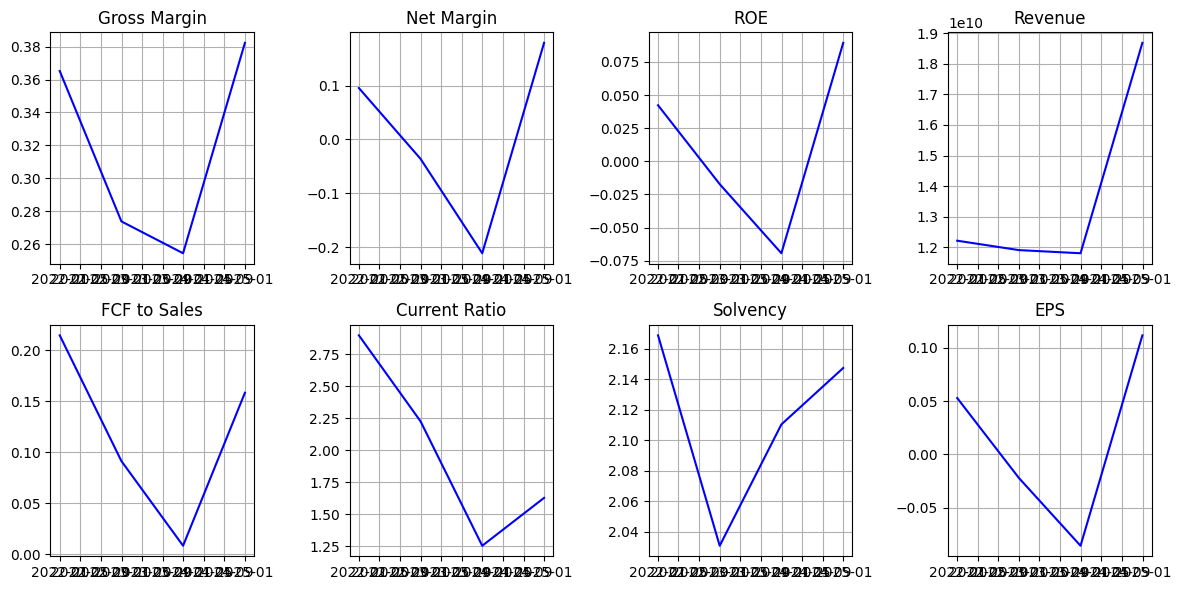

Múltiplos de ED


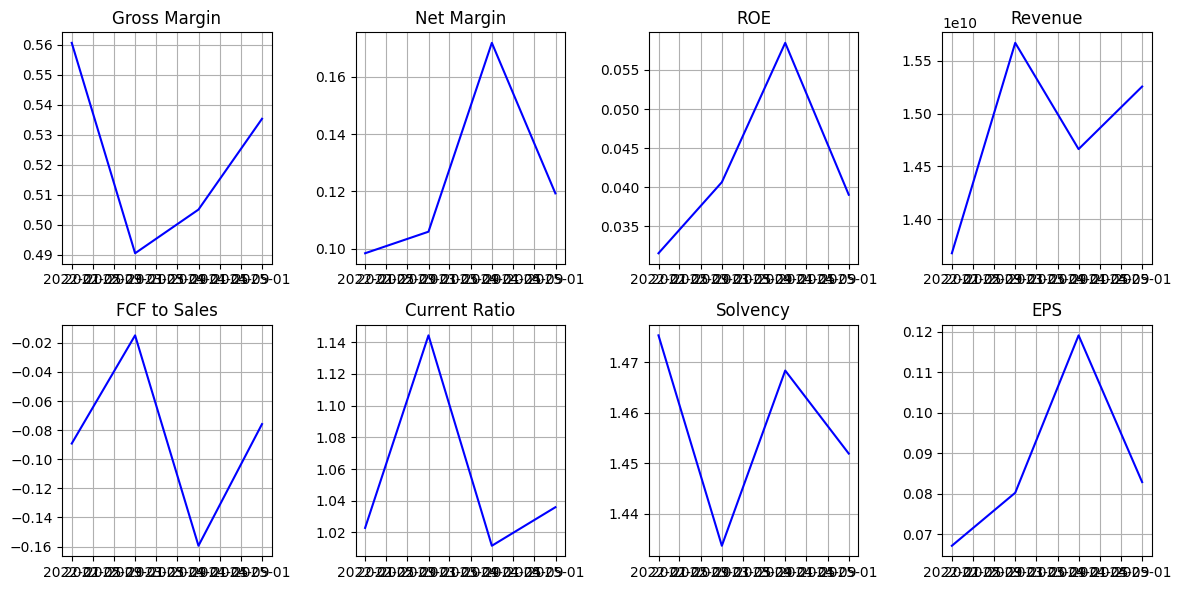

Múltiplos de WMT


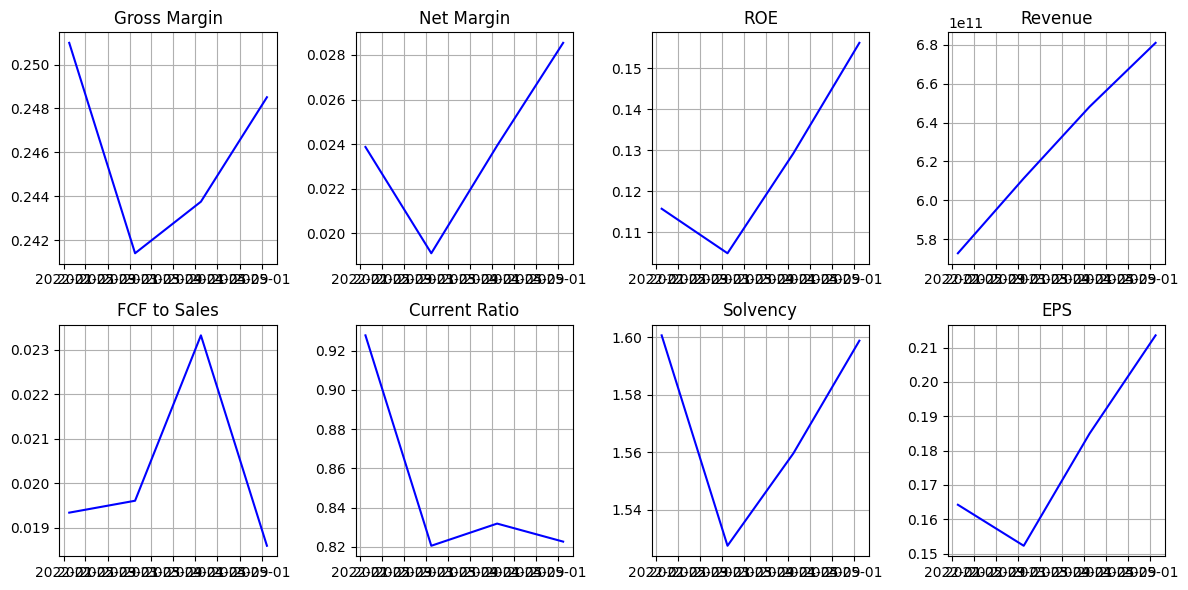

In [595]:
for ticker in tickers_valuation[:5]:

    bs, ist, cf = get_financials(ticker)

    gross_margin = ist.loc['Gross Profit']/ist.loc['Total Revenue']

    net_margin = ist.loc['Net Income Common Stockholders']/ist.loc['Total Revenue']

    roe = ist.loc['Net Income Common Stockholders'] / bs.loc['Total Capitalization']

    revenue = ist.loc['Total Revenue']

    fcf_to_sales = cf.loc['Free Cash Flow'] / ist.loc['Total Revenue']

    current_ratio = bs.loc['Current Assets']/bs.loc['Current Liabilities']

    solvency = bs.loc['Total Assets']/bs.loc['Total Liabilities Net Minority Interest']

    eps = ist.loc['Net Income Common Stockholders'] / bs.loc['Common Stock Equity']

    df_multiplos = pd.DataFrame({
        'Gross Margin': gross_margin,
        'Net Margin': net_margin,
        'ROE': roe,
        'Revenue': revenue,
        'FCF to Sales': fcf_to_sales,
        'Current Ratio': current_ratio,
        'Solvency': solvency,
        'EPS': eps
    })

    df_multiplos.sort_index()

    print(f'Múltiplos de {ticker}')

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    axes = axes.ravel()  # Aplana la matriz de ejes para indexar con un solo número

    for i, column in enumerate(df_multiplos.columns):
        axes[i].plot(df_multiplos.index, df_multiplos.iloc[:, i], c = 'blue')
        axes[i].set_title(column)
        axes[i].grid()
    plt.tight_layout()
    plt.show()

In [596]:
print(analizar_accion("BRK-B"))


Métricas de BRK-B:
Precio Actual: $485.00
EPS (Trailing): $37.54
Price-to-Book (P/B): 0.00
Price-to-Earnings (P/E): 12.92

Evaluación:
P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett).
P/E: 12.92. Compara con el S&P 500 (~15–20) para contexto.


In [597]:
print(analizar_accion("AZO"))


Métricas de AZO:
Precio Actual: $3769.26
EPS (Trailing): $147.75
Price-to-Book (P/B): -15.86
Price-to-Earnings (P/E): 25.51

Evaluación:
P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett).
P/E: 25.51. Compara con el S&P 500 (~15–20) para contexto.


In [598]:
print(analizar_accion("META"))


Métricas de META:
Precio Actual: $719.01
EPS (Trailing): $25.60
Price-to-Book (P/B): 9.80
Price-to-Earnings (P/E): 28.09

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 28.09. Compara con el S&P 500 (~15–20) para contexto.


In [599]:
print(analizar_accion("NEM"))


Métricas de NEM:
Precio Actual: $59.90
EPS (Trailing): $4.39
Price-to-Book (P/B): 2.15
Price-to-Earnings (P/E): 13.64

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 13.64. Compara con el S&P 500 (~15–20) para contexto.


In [600]:
print(analizar_accion("ED"))


Métricas de ED:
Precio Actual: $100.31
EPS (Trailing): $5.41
Price-to-Book (P/B): 1.52
Price-to-Earnings (P/E): 18.54

Evaluación:
P/B entre 1.2–1.6: Valuación razonable (rango histórico).
P/E: 18.54. Compara con el S&P 500 (~15–20) para contexto.


In [601]:
print(analizar_accion("WMT"))


Métricas de WMT:
Precio Actual: $98.36
EPS (Trailing): $2.34
Price-to-Book (P/B): 9.37
Price-to-Earnings (P/E): 42.03

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 42.03. Compara con el S&P 500 (~15–20) para contexto.


---

### Optimizar Pesos del Portafolio 

In [602]:
optimize_port = OptimizePortfolioWeights(ret, 0.0445)

#### Optimización Minima Varianza 

In [603]:
w_minvar= optimize_port.opt_min_var()
w_minvar

{'AZO': 0.18763258042470393,
 'BRK-B': 0.15628624207335098,
 'ED': 0.3969744805527625,
 'META': 0.15011678855477278,
 'NEM': 0.02557244150762236,
 'WMT': 0.08341746688678742}

#### Optimización Máximo de Sharpe

In [604]:
w_maxsharpe = optimize_port.opt_max_sharpe()
w_maxsharpe

{'AZO': 0.258704106472917,
 'BRK-B': 1.8826852829952132e-17,
 'ED': 0.18924556932507905,
 'META': 0.171646029825747,
 'NEM': 0.10353798566177012,
 'WMT': 0.2768663087144869}

#### Optimización Semi Varianza Target

In [605]:
w_semivar = optimize_port.opt_min_semivar(rets_benchmark)
w_semivar

{'AZO': 0.09928092645465403,
 'BRK-B': 0.29876380119332485,
 'ED': 0.17477760985929824,
 'META': 0.3092581512382798,
 'NEM': 0.015568475068196386,
 'WMT': 0.10235103618624668}

#### Optimización Máximo de Omega

In [606]:
omega = optimize_port.opt_max_omega(rets_benchmark)
omega

{'AZO': 7.686530473832027e-16,
 'BRK-B': 1.390300903042154e-16,
 'ED': 6.240565363374955e-16,
 'META': 0.999999999999998,
 'NEM': 4.460428774397548e-16,
 'WMT': 2.5874920735068268e-17}

---

### Backtesting

In [607]:
history = dynamic_backtesting(tickers, benchmark, capital=1000000, rf=.0445, months=12).simulation()
history

,Min Var,Sharpe,Semivar,Omega,Benchmark
Date,,,,,
NaT,1000000,1000000,1000000,1000000,1000000


### Visualización del Backtesting

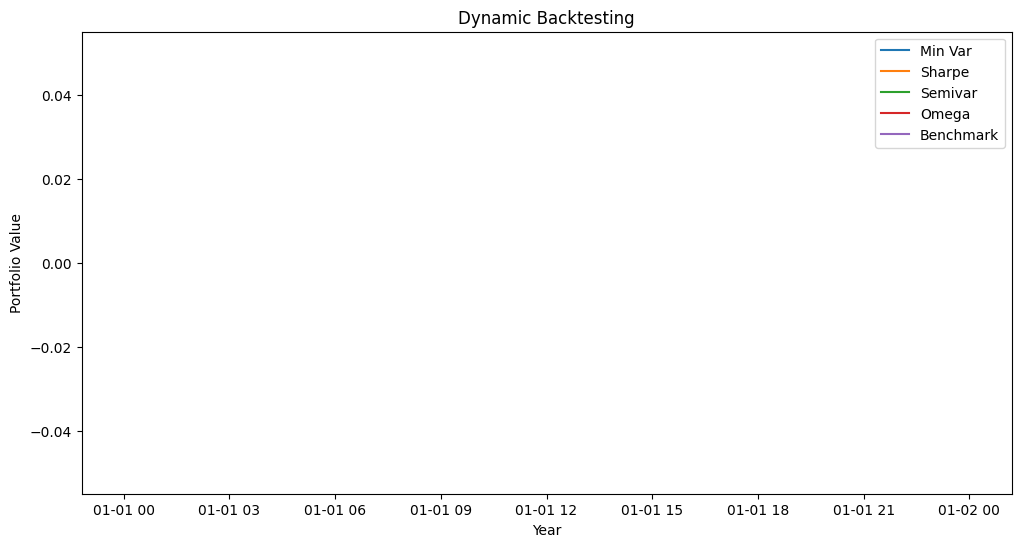

In [608]:
plt.figure(figsize=(12, 6))
plt.plot(history, label=history.columns)
plt.title('Dynamic Backtesting')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Portfolio Value')
plt.show()

### Métricas de Desempeño del Portafolio de Inversión


In [609]:
w_dict = {
    'Min Var': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Min Semivar': w_semivar,
    'Max Omega': omega,
    'Benchmark': 1
}

In [610]:
def get_metrics(history, rf):

    daily_rets=history.pct_change().dropna()

    rend_prom=daily_rets.mean()*252 
    std__=daily_rets.std()*np.sqrt(252) 
    RS=(rend_prom-rf)/std__
    downside=daily_rets[daily_rets<0].fillna(0).std()*np.sqrt(252) 
    upside=daily_rets[daily_rets>0].fillna(0).std()*np.sqrt(252) 
    Omega=upside/downside 
    Sortino=(rend_prom-rf)/downside


    metrics=pd.DataFrame([rend_prom, std__, RS, downside, upside, Omega, Sortino], 
                         index=['Rend', 'Vol', 'Sharpe', 'Downside', 'Upside', 'Omega', 'Sortino'])
    return metrics

get_metrics(history, .0445)

,Min Var,Sharpe,Semivar,Omega,Benchmark
Rend,NaN,NaN,NaN,NaN,NaN
Vol,NaN,NaN,NaN,NaN,NaN
Sharpe,NaN,NaN,NaN,NaN,NaN
Downside,NaN,NaN,NaN,NaN,NaN
Upside,NaN,NaN,NaN,NaN,NaN
Omega,NaN,NaN,NaN,NaN,NaN
Sortino,NaN,NaN,NaN,NaN,NaN


---